In [1]:
# !pip install matplotlib
# !pip install langdetect
# !pip install iso-639

In [65]:
import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from iso639 import languages
from langdetect import detect
import re
import gc
import copy
import csv

In [66]:
df = pd.read_csv('data/TMDB_tv_dataset_v3.csv')

In [67]:
df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes',
       'original_language', 'vote_count', 'vote_average', 'overview', 'adult',
       'backdrop_path', 'first_air_date', 'last_air_date', 'homepage',
       'in_production', 'original_name', 'popularity', 'poster_path', 'type',
       'status', 'tagline', 'genres', 'created_by', 'languages', 'networks',
       'origin_country', 'spoken_languages', 'production_companies',
       'production_countries', 'episode_run_time'],
      dtype='object')

# Feladatok


1. Azonosítsa a legtermékenyebb tévéműsor-alkotókat vagy produkciós cégeket az általuk készített műsorok száma alapján.
2. Fedezze fel a tévéműsorok népszerűségének trendjeit és fő tényezőit
    1. Elemezze a tévéműsorok nyelve és népszerűsége közötti kapcsolatot, és vizsgálja meg a nem angol nyelvű műsorok népszerűségét.
        1. Ennél célom, hogy az adatokat tudjam valahogy a nyelvek szerint normalizálni, hogy így mérhető legyen egy angol nyelvű, illetve egy idegen nyelvű sorozat sikeressége egymáshoz.
    2. Jósolja meg egy tévéműsor sikerét olyan jellemzők alapján, mint a szavazatszám, az átlag és a népszerűség.
5. Ezek mellett szeretném az adathalmazt alaposabban átvizsgálni és további összefüggéseket keresni.

# Elemzés

## Függvények

In [68]:
dummy_columns=[]

In [69]:
def get_language_name(language_code):
    try:
        return languages.get(part1=language_code).name
    except (KeyError, AttributeError):
        return "Unknown"  # Vagy tetszőleges érték, amit szeretnél az ismeretlen nyelv esetén

In [70]:
def dummy_creator(df, col ,dummy_columns):
    ps_dummies = pd.get_dummies(df[col], prefix = 'Type', drop_first = False)
    df = df.merge(ps_dummies, left_index = True, right_index = True, how = 'left')
    dummy_columns.extend(ps_dummies.columns)
    df=df.drop(col, axis=1)

    return df, dummy_columns

In [71]:
def dummy_creator_for_list_values(df, col, dummy_columns, language):
    df = df[df[col].apply(lambda x: isinstance(x, str))].copy()

    df['col_split'] = df[col].apply(lambda x: [s.strip() for s in re.split(', | & ', x)])

    df2=copy.deepcopy(df)

    del df
    
    for index, row in df2.iterrows():
        for item in row['col_split']:
            if (language):
                item=get_language_name(item)
            dummy_col = col + '_' + item
            dummy_columns.append(dummy_col)
            df2.at[index, dummy_col] = 1

    
    
    del df2[col]
    del df2['col_split']
        
    new_df = df2.copy()

    dummy_columns=list(set(dummy_columns))
    
    del df2
    return new_df, dummy_columns


In [72]:
df.isna().sum()

id                           0
name                         5
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 73323
adult                        0
backdrop_path            88798
first_air_date           31347
last_air_date            29498
homepage                115110
in_production                0
original_name                5
popularity                   0
poster_path              58786
type                         0
status                       0
tagline                 160262
genres                   67208
created_by              129558
languages                57051
networks                 69048
origin_country           31023
spoken_languages         57798
production_companies    107039
production_countries     89170
episode_run_time             0
dtype: int64

## 1. Feladat

In [88]:
def dict_for_list_values(df, col):
    df= df[df[col].apply(lambda x: isinstance(x, str))].copy()

    df['col_split'] = df[col].apply(lambda x: [s.strip() for s in re.split(', | & ', x)])

    col_dict={}

    for index, row in df.iterrows():
        for item in row['col_split']:
            if item not in (col_dict):
                col_dict[item]=1
            else:
                col_dict[item]+=1  

    ordered_col_dict = dict(sorted(col_dict.items(), key=lambda x: x[1], reverse=True))
    return ordered_col_dict

### production_companies

In [73]:
df_pc=df.copy()

In [75]:
df_pc['production_companies'].value_counts()

production_companies
TVB                                                                                       1356
BBC                                                                                        544
Estúdios Globo                                                                             531
NHK                                                                                        455
DR TV                                                                                      324
                                                                                          ... 
ABC News Studios, ABC News                                                                   1
Estúdios Globo, Glaz Entretenimento                                                          1
ZRF "Kamera"                                                                                 1
Lakeside Animation, Art Light, Look Mom! Productions, MetraFilms, Nukufilm, Riki Group       1
Feelgood Bangkok, h8 Studio  

In [76]:
df_pc['production_companies'].isna().sum()

107039

In [78]:
df_pc=df_pc.dropna(subset='production_companies')

In [89]:
dict_pc=dict_for_list_values(df_pc, 'production_companies')

In [90]:
dict_pc

{'TVB': 1388,
 'BBC': 867,
 'Estúdios Globo': 631,
 'NHK': 576,
 'Česká televize': 395,
 'Warner Bros. Television': 380,
 'Televisa': 347,
 'Universal Television': 346,
 'DR TV': 343,
 'TV 2': 333,
 'ZDF': 319,
 'ARTE': 316,
 'Fuji Television Network': 299,
 'GMA Entertainment Group': 292,
 'TBS': 284,
 'RAI': 278,
 'TV Tokyo': 272,
 'ATV Enterprises Limited': 271,
 'SVT': 269,
 'Amazon Studios': 267,
 'CCTV': 237,
 'Zone3': 231,
 'Toei Animation': 220,
 'France Télévisions': 218,
 'CBS Studios': 208,
 'Pink Pineapple': 205,
 'Toei Company': 203,
 '20th Century Fox Television': 202,
 'Studio Dragon': 201,
 'TVE': 195,
 'TV Asahi': 186,
 'DR': 185,
 'Sony Pictures Television Studios': 183,
 'CJ ENM': 176,
 'Nippon Television Network Corporation': 175,
 'TF1': 173,
 'bilibili': 165,
 'J.C.STAFF': 164,
 'NBC': 161,
 'SUNRISE': 160,
 'Paramount Television Studios': 155,
 'YOUKU': 155,
 'Hanna-Barbera Productions': 143,
 'Tencent Video': 142,
 'Channel 4 Television': 139,
 'National Geograp

In [82]:
df_pc

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,genres,created_by,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time,pc_split
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,...,"Sci-Fi & Fantasy, Drama, Action & Adventure","David Benioff, D.B. Weiss",en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0,"[Revolution Sun Studios, Television 360, Gener..."
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,...,"Crime, Drama",Álex Pina,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70,[Vancouver Media]
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,...,"Drama, Sci-Fi & Fantasy, Mystery","Matt Duffer, Ross Duffer",en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0,"[21 Laps Entertainment, Monkey Massacre Produc..."
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,...,"Action & Adventure, Drama, Sci-Fi & Fantasy",Frank Darabont,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42,"[AMC Studios, Circle of Confusion, Valhalla Mo..."
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,...,"Crime, Sci-Fi & Fantasy",Tom Kapinos,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45,"[Warner Bros. Television, DC Entertainment, Je..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165531,238291,Papá En Apuros,1,10,es,0,0.000,NaN,False,/exFz4KwNTt7vCxo6iC5wfHH75ik.jpg,...,"Comedy, Soap, Family",NaN,es,NaN,PE,Español,Chaski Producciones,Peru,60,[Chaski Producciones]
165534,239139,Кеша должен умереть,1,1,ru,0,0.000,NaN,False,NaN,...,"Drama, Comedy","Evgeniya Gromova, Konstantin Bogomolov",ru,NaN,RU,Pусский,"KION, Marmot Film, Продюсерская компания Валер...",NaN,0,"[KION, Marmot Film, Продюсерская компания Вале..."
165538,239143,Moon Landing Live,1,2,en,0,0.000,For the 50th anniversary of the Apollo 11 miss...,False,/n7cL9QopzJAcv7KmzeVRHyxGTyo.jpg,...,Documentary,NaN,en,Channel 4,GB,English,72 Films,United Kingdom,0,[72 Films]
165546,239151,光の戦士 ダイヤモンド・アイ,1,26,ja,0,0.000,NaN,False,NaN,...,Drama,NaN,ja,NaN,JP,日本語,TOHO,Japan,0,[TOHO]


In [56]:
del df_pc

### created_by

In [91]:
df_cb=df.copy()

In [92]:
df_cb['created_by'].value_counts()

created_by
Shotaro Ishinomori                                                   106
Adrián Suar                                                           64
John de Mol                                                           63
Simon Fuller                                                          48
Ekta Kapoor                                                           46
                                                                    ... 
Grits Carter, Antonia F. March, Jacqueline McKinley, Omar Shamout      1
Jo Sung-hee                                                            1
Jari Rantala                                                           1
Arif Khan                                                              1
Erik Range                                                             1
Name: count, Length: 25719, dtype: int64

In [93]:
df_cb['created_by'].isna().sum()

129558

In [94]:
df_cb=df_cb.dropna(subset='created_by')

In [95]:
dict_cb=dict_for_list_values(df_pc, 'created_by')

In [96]:
dict_cb

{'Shotaro Ishinomori': 101,
 'Adrián Suar': 69,
 'R.J. Nuevas': 45,
 'John de Mol': 44,
 'Na Young-seok': 43,
 'Joseph Barbera': 39,
 'William Hanna': 37,
 'Carla Albuquerque': 33,
 'Beto Ribeiro': 33,
 'Eiji Tsuburaya': 32,
 'David E. Kelley': 30,
 'Ekta Kapoor': 30,
 'Inés Rodena': 29,
 'Go Nagai': 26,
 'Rondel P. Lindayag': 26,
 'Dode Cruz': 26,
 'Dick Wolf': 25,
 'Ramón Campos': 24,
 'Mark Burnett': 24,
 'Aguinaldo Silva': 23,
 'Jean-Luc Azoulay': 23,
 'Joe Ruby': 21,
 'Gema R. Neira': 21,
 'Mark Goodson': 21,
 'Cris Morena': 20,
 'Ken Spears': 20,
 'Tim Heidecker': 20,
 'Stephen J. Cannell': 19,
 'Franc Roddam': 19,
 'RuPaul': 19,
 'Don Michael Perez': 19,
 'Charlie Parsons': 18,
 'Saburo Yatsude': 18,
 'Gilberto Braga': 18,
 'Walther Negrão': 18,
 'Momina Duraid': 18,
 'Yasushi Akimoto': 18,
 'Mui Siu-Ching': 18,
 'Suzette Doctolero': 18,
 'Ryan Murphy': 17,
 'Stan Lee': 17,
 'Walcyr Carrasco': 17,
 'Daniel Écija': 16,
 'Delia Fiallo': 16,
 'Sebastián Ortega': 16,
 'Bill Todman':

## 2. Feladat

### Adatok előkészítése

#### id

#### name

In [10]:
df=df.dropna(subset='name')

In [11]:
df.isna().sum()

id                           0
name                         0
number_of_seasons            0
number_of_episodes           0
original_language            0
vote_count                   0
vote_average                 0
overview                 73318
adult                        0
backdrop_path            88793
first_air_date           31345
last_air_date            29497
homepage                115105
in_production                0
original_name                0
popularity                   0
poster_path              58781
type                         0
status                       0
tagline                 160257
genres                   67203
created_by              129553
languages                57046
networks                 69043
origin_country           31018
spoken_languages         57793
production_companies    107034
production_countries     89165
episode_run_time             0
dtype: int64

#### number_of_seasons

#### number_of_episodes

#### original_language

In [12]:
df['original_language'].value_counts() 

original_language
en    75644
ja    13850
zh    13545
ko     7725
de     7454
      ...  
za        1
mn        1
ti        1
sw        1
aa        1
Name: count, Length: 106, dtype: int64

In [13]:
df['OG_language'] = df['original_language'].apply(lambda x: get_language_name(x))

In [14]:
len(df[df['OG_language']=='Unknown'])

1922

In [15]:
del df['original_language']

In [16]:
df, dummy_columns= dummy_creator(df, 'OG_language', dummy_columns)

#### vote_count

#### vote_average

#### overview

In [ ]:
del df['overview']

#### adult

In [17]:
df['adult'] = df['adult'].astype(np.int8)

#### backdrop_path

In [19]:
del df['backdrop_path']

#### first_air_date

In [20]:
df['first_air_date'] = pd.to_datetime(df['first_air_date'], errors='coerce')

In [21]:
df['first_air_date'].min()

Timestamp('1917-01-09 00:00:00')

In [22]:
def_date = pd.to_datetime('1888-10-14')

df['first_air_date'].fillna(def_date, inplace=True)

<Axes: >

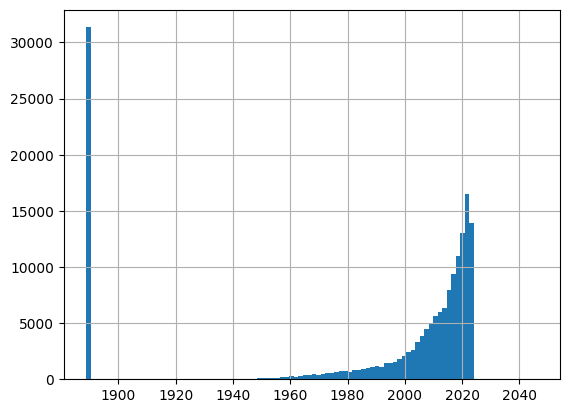

In [23]:
df['first_air_date'].hist(bins=100)

#### last_air_date

In [24]:
df['last_air_date'] = pd.to_datetime(df['last_air_date'], errors='coerce')

In [25]:
df['last_air_date'].min()

Timestamp('1917-01-09 00:00:00')

In [26]:
def_date = pd.to_datetime('1888-10-14')

df['last_air_date'].fillna(def_date, inplace=True)

<Axes: >

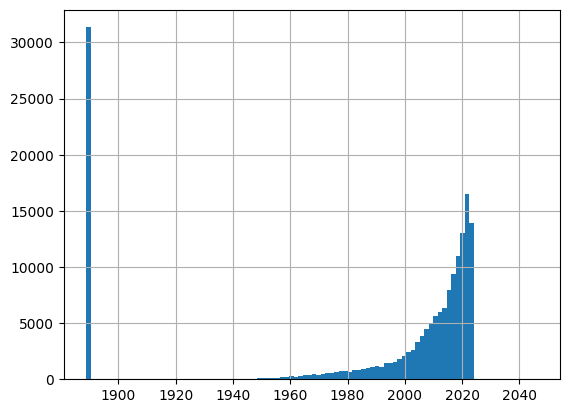

In [27]:
df['first_air_date'].hist(bins=100)

#### homepage

In [28]:
df['has_homepage'] = df['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)

In [29]:
del df['homepage']

#### in_production

In [30]:
df['in_production'] = df['in_production'].astype(np.int8)

#### original_name

In [31]:
del df['original_name']

#### popularity

<Axes: >

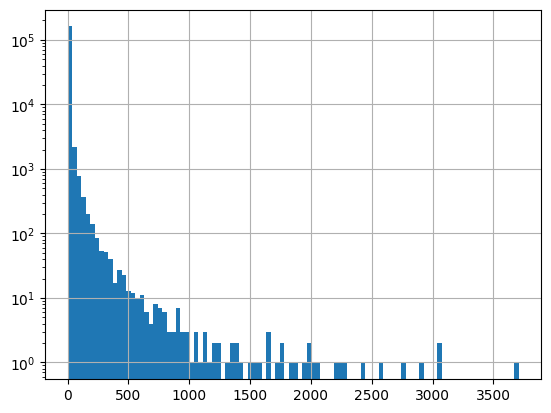

In [32]:
df['popularity'].hist(bins=100, log=True)

#### poster_path

In [33]:
del df['poster_path']

#### type

In [34]:
df['type'].value_counts()

type
Scripted       127041
Documentary     13452
Miniseries      10639
Reality          9511
Talk Show        2947
Video            1361
News              604
Name: count, dtype: int64

In [35]:
df, dummy_columns=dummy_creator(df, 'type', dummy_columns)

#### status

In [37]:
df['status'].value_counts()

status
Ended               92506
Returning Series    65432
Canceled             4561
In Production        2229
Planned               595
Pilot                 232
Name: count, dtype: int64

In [38]:
df, dummy_columns=dummy_creator(df, 'status', dummy_columns)

#### tagline

In [39]:
del df['tagline']

#### genres

In [40]:
print(df['genres'].value_counts())

genres
Documentary                                                                    17274
Drama                                                                          15953
Comedy                                                                         10200
Reality                                                                         7857
Animation                                                                       3296
                                                                               ...  
Animation, Action & Adventure, Drama, Comedy                                       1
Sci-Fi & Fantasy, Comedy, Reality, Action & Adventure                              1
Drama, Animation, Comedy, Action & Adventure                                       1
Animation, Action & Adventure, Comedy, Action & Adventure, Sci-Fi & Fantasy        1
Comedy, Documentary, Sci-Fi & Fantasy, Mystery                                     1
Name: count, Length: 2218, dtype: int64


In [41]:
df, dummy_columns= dummy_creator_for_list_values(df, 'genres', dummy_columns, False)

col_split
[Documentary]                                                                 17274
[Drama]                                                                       15953
[Comedy]                                                                      10200
[Reality]                                                                      7857
[Animation]                                                                    3296
                                                                              ...  
[Animation, Action, Adventure, Drama, Comedy]                                     1
[Sci-Fi, Fantasy, Comedy, Reality, Action, Adventure]                             1
[Drama, Animation, Comedy, Action, Adventure]                                     1
[Animation, Action, Adventure, Comedy, Action, Adventure, Sci-Fi, Fantasy]        1
[Comedy, Documentary, Sci-Fi, Fantasy, Mystery]                                   1
Name: count, Length: 2218, dtype: int64


In [42]:
df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes', 'vote_count',
       'vote_average', 'overview', 'adult', 'first_air_date', 'last_air_date',
       ...
       'genres_Western', 'genres_Kids', 'genres_Documentary', 'genres_Reality',
       'genres_Romance', 'genres_History', 'genres_Talk', 'genres_News',
       'genres_Musical', 'genres_Music'],
      dtype='object', length=160)

#### created_by

In [43]:
df['created_by'].value_counts()


created_by
Shotaro Ishinomori                                  82
Adrián Suar                                         63
Joseph Barbera, William Hanna                       41
R.J. Nuevas                                         37
Ekta Kapoor                                         36
                                                    ..
Michele Alhaique                                     1
Jorge Furtado, Carlos Gerbase                        1
Gabriel Nicoli                                       1
Thijs Römer, Peter Römer                             1
Kiran Viyyath, Sabareesh Sajjin, Krishnachandran     1
Name: count, Length: 23031, dtype: int64

In [44]:
del df['created_by']

#### languages

In [45]:
df['languages'].value_counts()



languages
en                28681
ja                 8900
zh                 6375
de                 5462
fr                 4709
                  ...  
fr, ja, it            1
en, ha, ig, yo        1
ar, he, en            1
ru, ar                1
az, fa                1
Name: count, Length: 1058, dtype: int64

In [46]:
df, dummy_columns= dummy_creator_for_list_values(df, 'languages', dummy_columns, True)

col_split
[en]                28681
[ja]                 8900
[zh]                 6375
[de]                 5462
[fr]                 4709
                    ...  
[fr, ja, it]            1
[en, ha, ig, yo]        1
[ar, he, en]            1
[ru, ar]                1
[az, fa]                1
Name: count, Length: 1058, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_14820\61098106.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.at[index, dummy_col] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_14820\61098106.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.at[index, dummy_col] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_14820\61098106.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [47]:
df

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,overview,adult,first_air_date,last_air_date,...,languages_Esperanto,languages_Sango,languages_Sanskrit,languages_Maltese,languages_Bashkir,languages_Afar,languages_Cree,languages_Central Khmer,languages_Romansh,languages_Lao
0,1399,Game of Thrones,8,73,21857,8.442,Seven noble families fight for control of the ...,0,2011-04-17,2019-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71446,Money Heist,3,41,17836,8.257,"To carry out the biggest heist in history, a m...",0,2017-05-02,2021-12-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66732,Stranger Things,4,34,16161,8.624,"When a young boy vanishes, a small town uncove...",0,2016-07-15,2022-07-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1402,The Walking Dead,11,177,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,0,2010-10-31,2022-11-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63174,Lucifer,6,93,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",0,2016-01-25,2021-09-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165552,239158,Na Nare Hana Nare,1,1,0,0.000,"""The feeling of wanting to cheer someone on......",0,1888-10-14,1888-10-14,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165553,239159,Kontraste – Die Reporter,1,22,0,0.000,NaN,0,2019-03-06,2023-09-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165556,238319,Kino Favoriten,1,16,0,0.000,NaN,0,2017-01-07,2018-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165557,238320,Kinozeit,1,18,0,0.000,NaN,0,2011-10-01,2013-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### networks

In [48]:
df['networks'].value_counts()

networks
Netflix                                                               1685
BBC One                                                               1557
YouTube                                                               1316
BBC Two                                                               1293
NBC                                                                   1258
                                                                      ... 
LeTV, iQiyi, Mango TV, Tencent Video                                     1
WAPA-TV, Univision, Mega TV , TeleOnce                                   1
Youku, Tencent Video, CCTV-3, CCTV-4, CCTV-14, CCTV, iQiyi, CCTV-1       1
NDR Fernsehen, BR Fernsehen                                              1
Che, DTV, more.tv                                                        1
Name: count, Length: 7005, dtype: int64

In [49]:
df, dummy_columns= dummy_creator_for_list_values(df, 'networks', dummy_columns, False)

col_split
[Netflix]                                                               1685
[BBC One]                                                               1557
[YouTube]                                                               1316
[BBC Two]                                                               1293
[NBC]                                                                   1258
                                                                        ... 
[WAPA-TV, Univision, Mega TV, TeleOnce]                                    1
[Youku, Tencent Video, CCTV-3, CCTV-4, CCTV-14, CCTV, iQiyi, CCTV-1]       1
[NDR Fernsehen, BR Fernsehen]                                              1
[tv asahi, Toei Tokusatsu Fan Club]                                        1
[Che, DTV, more.tv]                                                        1
Name: count, Length: 6989, dtype: int64


C:\Users\User\AppData\Local\Temp\ipykernel_14820\61098106.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.at[index, dummy_col] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_14820\61098106.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2.at[index, dummy_col] = 1
C:\Users\User\AppData\Local\Temp\ipykernel_14820\61098106.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [50]:
df

,id,name,number_of_seasons,number_of_episodes,vote_count,vote_average,overview,adult,first_air_date,last_air_date,...,networks_Jewelry Television,networks_Sky Arte (IT),networks_NTV Variety,networks_Pac-12 Network,networks_MUTV,networks_Lionsgate Television,networks_FWTV,networks_Discovery Turbo Brasil,networks_LLINK,networks_EXQI Plus
0,1399,Game of Thrones,8,73,21857,8.442,Seven noble families fight for control of the ...,0,2011-04-17,2019-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71446,Money Heist,3,41,17836,8.257,"To carry out the biggest heist in history, a m...",0,2017-05-02,2021-12-03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,66732,Stranger Things,4,34,16161,8.624,"When a young boy vanishes, a small town uncove...",0,2016-07-15,2022-07-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1402,The Walking Dead,11,177,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,0,2010-10-31,2022-11-20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63174,Lucifer,6,93,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",0,2016-01-25,2021-09-10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165551,239157,Konny Goes Wild,1,4,0,0.000,NaN,0,2019-08-19,2019-09-09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165553,239159,Kontraste – Die Reporter,1,22,0,0.000,NaN,0,2019-03-06,2023-09-06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165556,238319,Kino Favoriten,1,16,0,0.000,NaN,0,2017-01-07,2018-11-17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
165557,238320,Kinozeit,1,18,0,0.000,NaN,0,2011-10-01,2013-03-01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
sum(df.isna().sum())

221711029

#### origin_country

In [52]:
df['origin_country'].value_counts()

origin_country
US                13735
GB                 7502
JP                 6578
DE                 4786
CN                 3284
                  ...  
IE, US                1
SU, US, GB            1
FR, GR                1
CN, HK, TW, SG        1
BE, FI, FR            1
Name: count, Length: 583, dtype: int64

#### spoken_languages

In [53]:
df['spoken_languages'].value_counts()

spoken_languages
English                                                                                      26210
日本語                                                                                           6456
Deutsch                                                                                       5130
Français                                                                                      4010
普通话                                                                                           3865
                                                                                             ...  
Español, English, Pусский, Deutsch, Polski, Italiano, پښتو, Český, ελληνικά, 한국어/조선말, 普通话        1
English, Italiano, اردو                                                                          1
普通话, Bahasa indonesia, Pусский                                                                   1
Deutsch, Français, Italiano, Slovenčina, Český, Magyar                                      

In [54]:
del df['spoken_languages']

#### production_countries

In [58]:
df2['production_countries'].value_counts()

production_countries
United States of America                                         7618
Japan                                                            6002
Germany                                                          4444
United Kingdom                                                   4114
China                                                            2926
                                                                 ... 
South Korea, Mongolia, Switzerland                                  1
Germany, France, Canada, Netherlands, Austria, United Kingdom       1
Belgium, Netherlands, South Africa                                  1
Hong Kong, United States of America, Thailand, Belgium              1
Belgium, Denmark, Finland, France                                   1
Name: count, Length: 1066, dtype: int64

#### production_companies

#### episode_run_time 

In [59]:
sum(df2.isna().sum())

221682314

In [60]:
df2[dummy_columns]=df2[dummy_columns].apply(lambda x: x.fillna(0))

In [61]:
sum(df2.isna().sum())

41625

In [62]:
df2.to_csv('df.csv', index=False)

In [63]:
dummy_columns[857]

'networks_Fullscreen'

In [64]:
with open('data/dummy_cols.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(dummy_columns)

UnicodeEncodeError: 'charmap' codec can't encode characters in position 100-103: character maps to <undefined>